
## Analytic Solutions 2D

Underworld provides a set of analytic solutions to Stokes flow problems.

In this example, analytic solution objects are used to configure an analogous numerical system. The numerical solution may then be compared to the exact solution (again provided by the analytic solution object).

The first part of this file considers a single analytic model and the corresponding numerical solution.

We then run a series simulations across different resolutions to extract error convergence information. This second part is repeated for a set of analytic models.

In [1]:
import underworld as uw
import glucifer
from underworld import function as fn
import math
import numpy as np
import collections

uw.matplotlib_inline()

### First consider the a single analytic model and the construction of the numerical analogue.  



In [2]:
# Find all available 2D solutions. 
# Use ordered dict to preserve alphabetical ordering
solns_avail = collections.OrderedDict()
for soln_name in dir(fn.analytic):
    if soln_name[0] == "_": continue  # if aaaprivate member, ignore
    # get soln class
    soln = getattr(fn.analytic,soln_name)
    # check if actually soln
    if issubclass(soln, fn.analytic._SolBase):
        # construct
        solnguy = soln()
        # keep only 2d solns
        if solnguy.dim == 2:
            print("Solution added: {}".format(soln_name))
            solns_avail[soln_name] = soln()


Solution added: SolA
Solution added: SolB
Solution added: SolCx
Solution added: SolDB2d
Solution added: SolKx
Solution added: SolKz
Solution added: SolM
Solution added: SolNL


In [3]:
# Solution to view:
view_soln  = "SolNL"
view_order = 2
view_res   = 32

# Solutions to regress:
regress_solns = "all"                 # for all
# regress_solns = ""                     # for none
# regress_solns = "SolCx SolDB2d "       # list required solutions for subset
# regress_solns = view_soln              # view solution

regress_res = [16,32,64]

if len(regress_res)<2:
    raise RuntimeError("At least 2 resolutions required for regression analysis.")

In [4]:
solns = collections.OrderedDict()
if regress_solns == "all":
    solns.update(solns_avail)
else:
    for sol in regress_solns.split():
        solns[sol] = solns_avail[sol]

We create a function which constructs the numerical system. This will be used again later when we do convergence testing.

In [5]:
def get_numerical( soln, res=32, order=1 ):
    '''
    Creates the numerical system corresponding to the provided analytic system.
    
    Parameters
    ----------
    soln : uw.function.analytic._SolBase
        The analytic system
    res : int
        System resolution. Same resolution is used for each axis.
    order : int
        System numerical order. 
        
    '''
    if order == 1:
        els = "Q1/dQ0"
    elif order == 2:
        els = "Q2/dPc1"
    else:
        raise ValueError("Provided system order should be 1 or 2.")

    
    mesh  = uw.mesh.FeMesh_Cartesian(elementType=els, elementRes=(res,res),minCoord=(0.,0.),maxCoord=(1.,1.))
    vel   = uw.mesh.MeshVariable(mesh,2)
    press = uw.mesh.MeshVariable(mesh.subMesh, 1)
    vel.data[:]   = (0.,0.)
    press.data[:] = 0.

    bcs = soln.get_bcs(vel)

    stokes = uw.systems.Stokes(vel,press,soln.fn_viscosity,fn_bodyforce=soln.fn_bodyforce, conditions=[bcs,])
    solver = uw.systems.Solver(stokes)
    if uw.nProcs()==1:
        solver.set_inner_method("lu")
    solver.set_inner_rtol(1.e-8)
    solver.set_outer_rtol(1.e-8)


    return mesh, vel, press, solver

Go ahead and create the numerical system analogue

In [6]:
soln = solns_avail[view_soln]
mesh, vel, press, solver = get_numerical( soln, order=view_order, res=view_res)

In [7]:
# create figure for bodyforce
bf_mag = fn.math.sqrt(fn.math.dot(soln.fn_bodyforce,soln.fn_bodyforce))
fig_bodyforce = glucifer.Figure(figsize=(500,570), background="white", margin="1", title="Body Force")
fig_bodyforce.append(glucifer.objects.Surface(mesh,bf_mag,colours="polar"))
fig_bodyforce.append(glucifer.objects.VectorArrows(mesh,soln.fn_bodyforce))

In [8]:
# also figure for viscosity
fig_viscosity = glucifer.Figure(figsize=(500,570), background="white", margin="1", title="Viscosity")
fig_viscosity.append(glucifer.objects.Surface(mesh,soln.fn_viscosity,colours="spectral", logscale=False))

The body force and viscosity form inputs to the numerical system

,

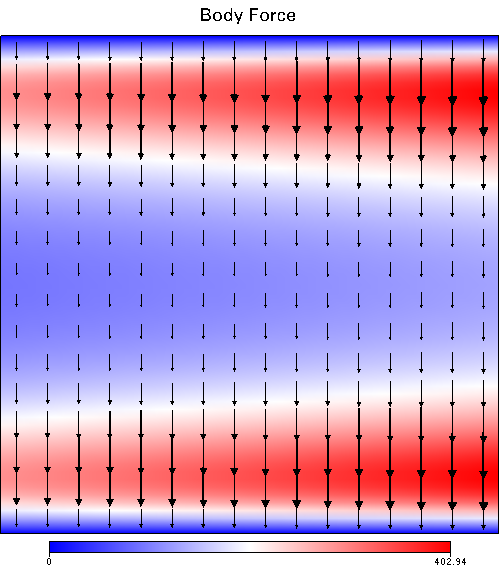
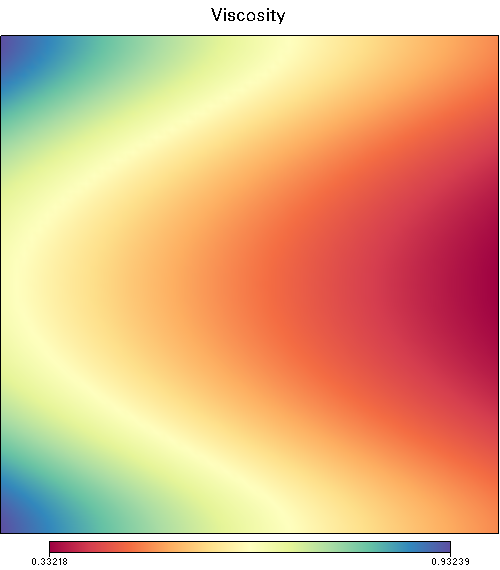

In [9]:
glucifer.Figure.show_grid((fig_bodyforce,fig_viscosity))

In [10]:
# generate our numerical solution
solver.solve()

In [11]:
# create figure for the velocity solution
fig_velocity = glucifer.Figure(figsize=(500,570), background="white", margin="1", title="Velocity")
vel_mag = fn.math.sqrt(fn.math.dot(vel,vel))
fig_velocity.append(glucifer.objects.Surface(mesh,vel_mag,colours=['white',"darkblue"]))
fig_velocity.append(glucifer.objects.VectorArrows(mesh,vel))

In [12]:
# create figure for the pressure solution
fig_pressure = glucifer.Figure(figsize=(500,570), background="white", margin="1", title="Pressure")
fig_pressure.append(glucifer.objects.Surface(mesh,press,colours=['white',"darkred"],onMesh=True))

,

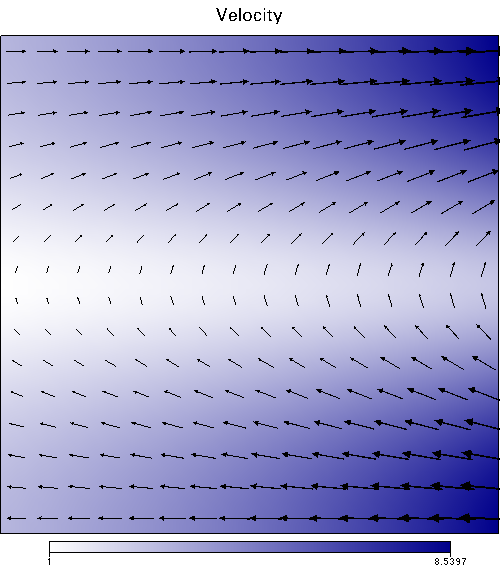
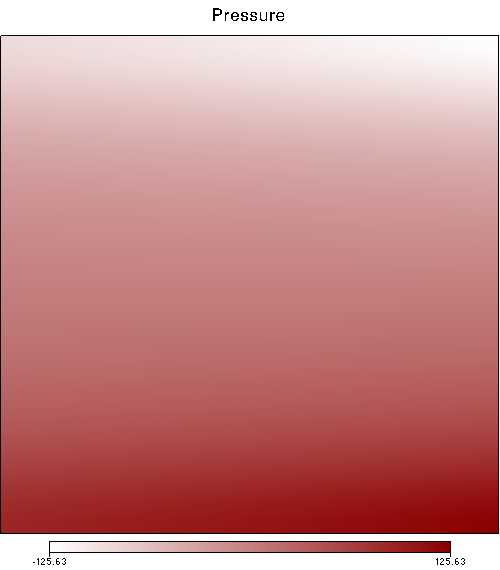

In [13]:
glucifer.Figure.show_grid((fig_velocity,fig_pressure))

,

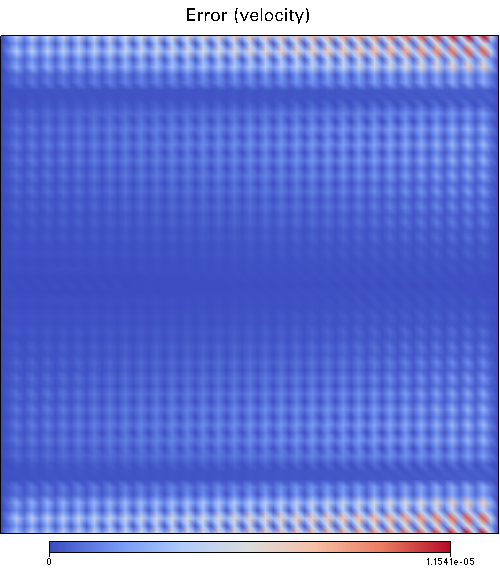
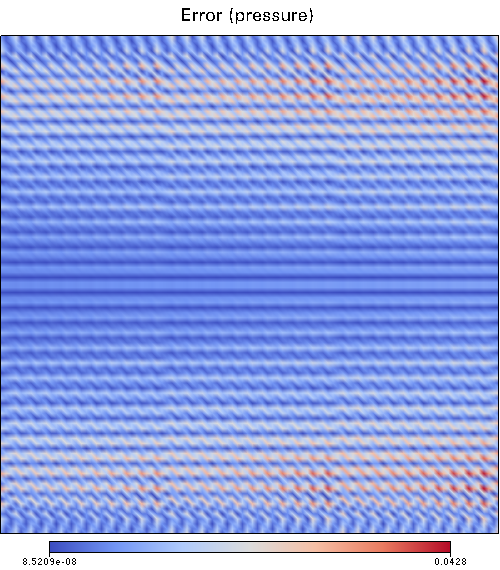

In [14]:
# Visualise the error field
def fn_error(numeric, analytic):
    '''
    Returns scaled absolute error Function objects.
    '''
    delta        = analytic - numeric
    absolute_err = fn.math.sqrt(fn.math.dot(delta,delta))

    analytic_dot = fn.math.dot(analytic,analytic)
    rms_sol_ana = np.sqrt(uw.utils.Integral( analytic_dot, mesh ).evaluate())

    return absolute_err / rms_sol_ana

abserr = fn_error(vel,soln.fn_velocity)
err_fig_vel = glucifer.Figure(figsize=(500,570), margin="1", title="Error (velocity)")
err_fig_vel.append(glucifer.objects.Surface(mesh, abserr, logscale=False, colours="coolwarm"))

# As the pressure solution is on the submesh, we project
# the exact solution onto a new submesh variable for 
# a clearer visual comparison.
press_soln_proj = uw.mesh.MeshVariable(mesh.subMesh, 1)
uw.utils.MeshVariable_Projection(press_soln_proj,soln.fn_pressure, type=0).solve()

abserr = fn_error(press,press_soln_proj)
err_fig_press = glucifer.Figure(figsize=(500,570), margin="1", title="Error (pressure)")
err_fig_press.append(glucifer.objects.Surface(mesh, abserr, logscale=False, colours="coolwarm", onMesh=False))

glucifer.Figure.show_grid((err_fig_vel,err_fig_press))

In [15]:
def rms_error(numeric, analytic, mesh):
    '''
    Calculates the rms error.
    
    Returns
    -------
    abs, abs_scaled: float
        The absolute and scaled absolute errors.
    '''

    delta     = analytic - numeric
    delta_dot = fn.math.dot(delta,delta)

    analytic_dot = fn.math.dot(analytic,analytic)
    
    # l2 norms
    rms_err_abs = np.sqrt(uw.utils.Integral(    delta_dot, mesh ).evaluate())
    rms_sol_ana = np.sqrt(uw.utils.Integral( analytic_dot, mesh ).evaluate())
    rms_err_sca = rms_err_abs / rms_sol_ana
        
    return rms_err_abs, rms_err_sca

### Now perform convergence rate tests 

In [16]:
# Note that default parameters have been used for all solns.
# Default parameters are chosen such that all interfaces 
# fall on element boundaries when power of 2 mesh resolutions 
# are chosen.
velocity_key = "Velocity"
pressure_key = "Pressure"

resolutions = regress_res
dx = np.reciprocal(resolutions,dtype='double')

soln_results = collections.OrderedDict()

for soln_name in solns.keys():
    solnguy = solns[soln_name]
    print("Performing simulations for solution: {}".format(soln_name))

    for order in [1,2]:
        err_pre = collections.OrderedDict()
        err_vel = collections.OrderedDict()

        for res in resolutions:
            mesh, vel, press, solver = get_numerical( solnguy, res, order=order )
#             print("Performing simulations for solution: {}, res: {}, order: {}".format(soln_name,res,order))
            solver.solve()

            err_vel[res] = rms_error(   vel, solnguy.fn_velocity, mesh )[1][0]
            err_pre[res] = rms_error( press, solnguy.fn_pressure, mesh )[1][0]

            soln_results[(soln_name,order, velocity_key)] = err_vel
            soln_results[(soln_name,order, pressure_key)] = err_pre


Performing simulations for solution: SolA
Performing simulations for solution: SolB
Performing simulations for solution: SolCx
Performing simulations for solution: SolDB2d


/opt/underworld2/underworld/systems/_bsscr.py:459: UserWarning: A PETSc error has been encountered during the solve. Solution fields are most likely erroneous. 

This error is probably due to an incorrectly constructed linear system. Please check that your boundary conditions are consistent and sufficient and that your viscosity is positive everywhere. If you are deforming the mesh, ensure that it has not become tangled. 

The resultant KSPConvergedReasons are (f_hat, outer, backsolve) (0,-3,0).


  warnings.warn(estring)


Performing simulations for solution: SolKx
Performing simulations for solution: SolKz
Performing simulations for solution: SolM
Performing simulations for solution: SolNL


In [17]:
fitfn = lambda x,a,b: a+b*x
def get_linear_fit(x,y):
    '''
    Returns best fit (a,b) for $ln(y)=a+b*ln(x)$ for provided
    set of points (x,y).
    '''
    import scipy.optimize
    fit = scipy.optimize.curve_fit(fitfn,  np.log(x),  np.log(y))
    return fit[0]

def get_fit_line(dx, fit):
    '''
    Evaluates fit across a set of points.
    '''
    dxmin = 0.9*dx.min()
    dxmax = 1.1*dx.max()
    xpts = np.linspace(dxmin,dxmax,20)
    ypts = np.exp(fitfn(np.log(xpts),*fit))
    return xpts, ypts

Rejecting SolDB2d fit = 6.75601927046, expected = 1. Results not rendered.


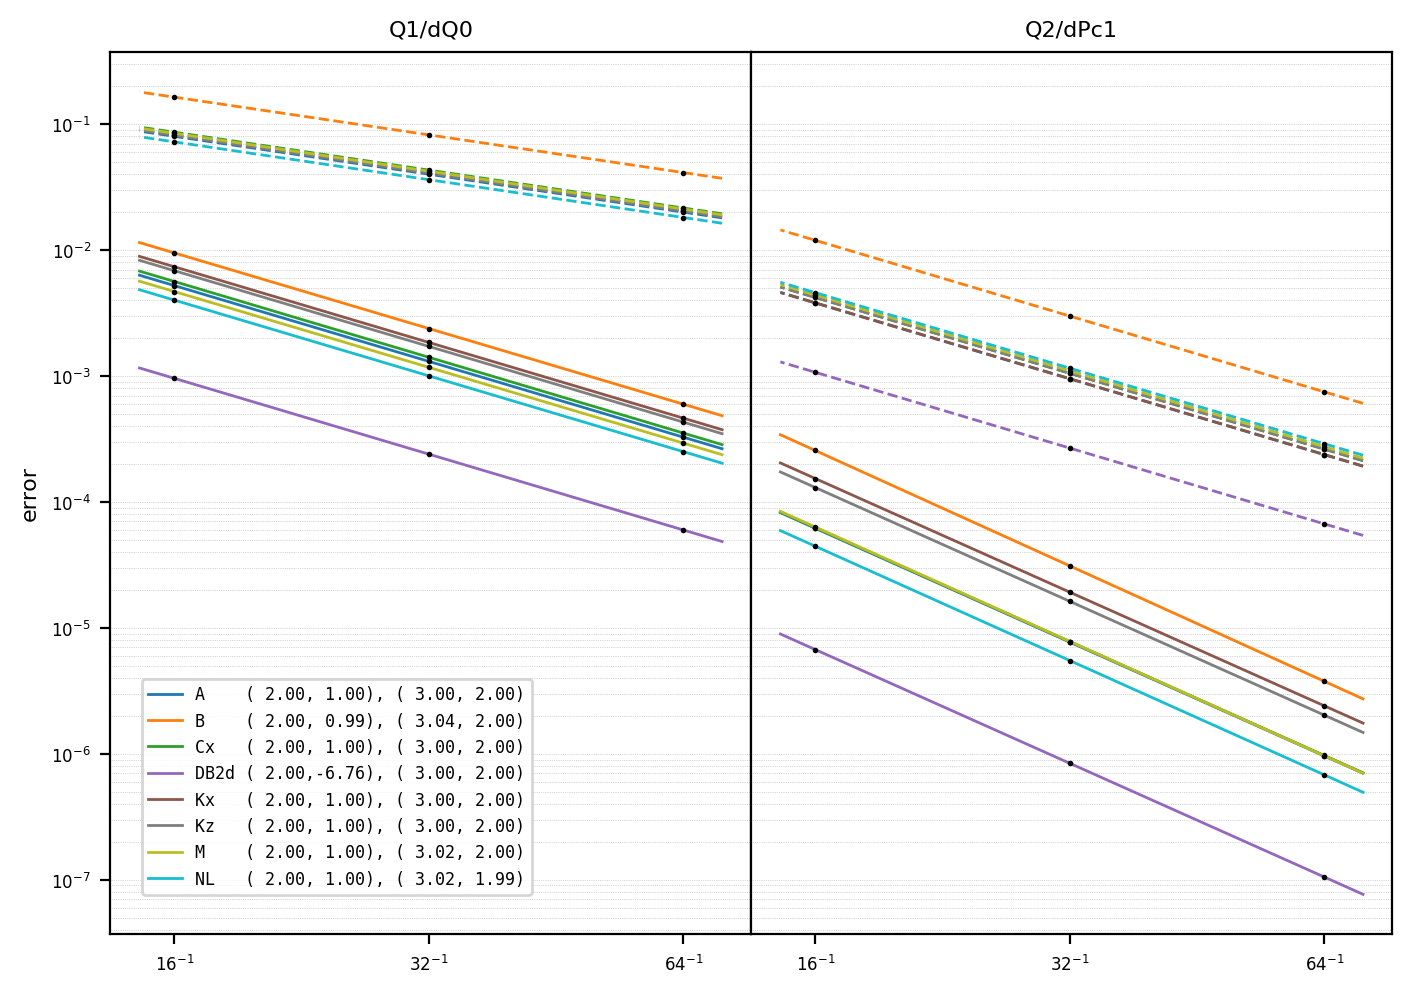

In [37]:
if uw.rank()==0:
    import matplotlib.pyplot as plt
    fig = plt.figure(dpi=200, figsize=(8.27, 11.69/2.))
    plt.subplots_adjust(wspace=.0)
    
    # create some consistent colours & linestyles
    from matplotlib.pyplot import cm
    colours = cm.tab10(np.linspace(0,1,len(solns.keys())))
    scheme = {}
    for it,sol in enumerate(solns.keys()):
        scheme[(sol,pressure_key)] = (colours[it],'--')
        scheme[(sol,velocity_key)] = (colours[it],'-')


    def create_ax(pos, title=None, other_ax=None):
        ax = plt.subplot(1,2,pos,xscale='log', yscale='log', sharey=other_ax)
        ax.set_title(title,fontsize=8)
        ax.invert_xaxis()
        ax.xaxis.set_ticks(dx)
        ax.xaxis.set_ticklabels(["$ {{ {} }}^{{-1}}$".format(x) for x in resolutions])
        ax.grid(axis="y", which="both",linestyle=':',linewidth=0.25)
        ax.tick_params(axis='both', which='major', labelsize=8)
#         ax.set_xlabel("dx", fontsize=8)
        if not other_ax:
            ax.set_ylabel("error", fontsize=8)

        # disable minor ticks marks on axis
        for tic in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
        for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
            tic.label.set_fontsize(6)
        # disable tick marks on rhs of other axis
        if other_ax:
            for tic in ax.yaxis.get_major_ticks():
                tic.tick1On = tic.tick2On = False
                tic.label1On = tic.label2On = False
        return ax
    
    axes = {}
    axes[1] = create_ax(1, title="Q1/dQ0")
    axes[2] = create_ax(2, title="Q2/dPc1", other_ax=axes[1] )
    
    # get fit results now so we can set plot labels
    fits = {}
    for key, err in soln_results.iteritems():
        fits[key] = get_linear_fit(dx,err.values())

    # keep set of lines for legend
    lines = collections.OrderedDict()
    for key, err in soln_results.iteritems():
        soln_name = key[0]
        order     = key[1]
        velpres   = key[2]
        ax        = axes[order]
        fit       = fits[key]
        fitdata   = get_fit_line(dx,fit)    

        expected_order = order if (key[2]==pressure_key) else order+1
        if not np.isclose(fit[1],expected_order,atol=1.5e-1):
            print("Rejecting {} fit = {}, expected = {}. Results not rendered.".format(soln_name,fit[1],expected_order))
            fits[key][1] *= -1.  # add neg just to make it stand out in the legend
            continue      # do not render

        col,ls = scheme[(soln_name,velpres)]
        line = ax.plot(*fitdata, linewidth=1., color=col, linestyle=ls)
        if velpres == velocity_key:
            lines[soln_name] = line
        
        ax.plot(dx, err.values(), 'o', markersize=1., color='black')

    lbls = []
    lns = []
    for soln_name in lines.keys():
        vel_1   = fits[(soln_name,1,velocity_key)][1]
        pre_1   = fits[(soln_name,1,pressure_key)][1]
        vel_2   = fits[(soln_name,2,velocity_key)][1]
        pre_2   = fits[(soln_name,2,pressure_key)][1]
        lbls.append("{} ({: .2f},{: .2f}), ({: .2f},{: .2f})".format(soln_name[3:].ljust(4), vel_1, pre_1, vel_2, pre_2))
        lns.append(lines[soln_name][0])
    
    fig.legend( lns, lbls, loc = (0.1, 0.1), prop={'family': 'monospace', 'size':6})